# Bioreactor feedback control design
<div class="alert alert-block alert-warning">
    <b>Warning:</b> Some quotes taken from Wikipedia pages on <a href="https://en.wikipedia.org/wiki/Control_theory">control theory</a> and <a href="https://en.wikipedia.org/wiki/PID_controller">PID control</a> without attribution, do not publish as is.</div>

**CONTROLLER DESIGN ROOT LOCUS FIGURES ARE MESSED UP BECAUSE I WAS TREATING $K_P$ AS IF IT WAS GREATER THAN ZERO DURING THE CONTROLLER DESIGN, BUT IT IS LESS THAN ZERO. FIX...**

**Control variable ($u(t)$)**: LED panel PWM signal duty cycle.

**Process variable ($y(t)$)**: carbon dioxide concentration of ambient environment, measured with a Senseair S8/LP8 sensor.

**Set point ($r$)**: 800 ppm.

$e(t)=y(t)-r$ is the error signal, which is applied as feedback to generate a control action, turning the lights up or down, in order to bring the process variable closer to the set point.

The following is a fairly basic closed loop controller.

![](basic_loop.png)

The closed loop transfer function is as follows.

$$H(s)=\frac{P(s)C(s)}{1-P(s)C(s)}$$

where $Y(s)=H(s)R$. Note the negative in the denominator, which comes from the addition of $y(t)$ at the summing junction.

In [1]:
import control
import matplotlib.pyplot as pp
import numpy as np
%matplotlib inline

## Finding the plant $P(s)$
### Determining the equation
In our case, the plant is found via system identification, assuming all variables except light intensity and photosynthesis rate are held constant. A voltage is applied to the lights, which produces a light intensity that is applied to the algae, which produces a certain photosynthesis rate. The Blackman equation for photosynthesis indicates that the photosynthesis response to light intensity will be linear, as long as the light intensity and CO2 concentration are within a range that does not saturate the photosynthesis rate. 

![](https://www.biology-pages.info/R/RateLimits.jpg)

Because photosynthesis rate is equivalent with CO2 rate, the result can then be integrated to determine the resulting CO2 concentration. The plant, which is also the open loop transfer function, is represented as follows:

$$P(s)=\frac{Y(s)}{U(s)}=\frac{K_L K_P}{s}$$

Think of the plant as the dynamics of the actuator, the lights ($K_L$), in series with the dynamics of the the algae ($\frac{K_P}{s}$). *is it appropriate to say that the integrator is part of the algae dynamics? I kind of don't think so, it happens after the disturbance.* 

[image of the control system with reference value and disturbance]

### Determining the gains
From system identification experiments:

In [2]:
K_L = 41.40; # lux / % duty cycle
K_P = -0.3493e-4; # ppm / lux*s

## Designing a proportional controller $C(s)$

Let's design a controller that will respond in the following way, where $U = E*C$ is the PWM duty cycle. 

$$U = \begin{cases} 0, & \mbox{if } y < 800ppm \\ \mbox{between }0\mbox{ and }100, & \mbox{if } 800ppm < y < 2800 ppm \\ 100, & \mbox{if } y > 2800ppm\end{cases}$$

The upper and lower saturation bounds will occur because the PWM duty cycle is unable to get above 100 or below 0; that is, the lights have a maximum and minimum brightness. The linear variation from 10 to 100 in the range of CO2 concentrations will occur through proportional control. So, $C=K_{prop}$. When $y(t) = 800 ppm$, $e(t)=0ppm$, so $0*K_{prop}= 0$. When $y(t)=2800ppm$, $e(t)=2000ppm$, so $2000*K_{prop}=100\implies K_{prop}=0.05\frac{\%}{ppm}$.



In [27]:
s = control.TransferFunction.s
C_prop = 0.05
P = K_P*K_L
print('P compensated OLTF:\n',(1/s)*C_prop*P)

P compensated OLTF:
 
-7.231e-05
----------
    s



Now we calculate the closed loop transfer function, which allows us to determine the system response to a disturbance input. Since $\delta(s)$ is our desired input, we rearrange the system so that $\frac{1}{s}$ is in the forward path and $C(s)$, $P(s)$ and $R$ are in the feedback path. So,

$$E = \delta+(Y+R)PC$$

$$Y = E*\frac{1}{s}$$
so
$$\delta = (s-PC)Y-PCR$$

$$Y = \frac{\frac{1}{s}}{1-\frac{1}{s}PC}\delta+\frac{\frac{1}{s}PC}{1-\frac{1}{s}PC}R$$

$$H_\delta(s) = \frac{Y(s)}{\delta(s)}=\frac{\frac{1}{s}}{1-\frac{1}{s}P(s)C(s)}=\frac{\frac{1}{s}}{1-\frac{1}{s}K_PK_LK_{prop}}$$

how to add reference value:
- https://youtu.be/toGBpjMZYPI?t=497

In [28]:
H_d_prop = (1/s)/(1-(1/s)*C_prop*P)
print('P compensated CLTF:\n',H_d_prop)

P compensated CLTF:
 
        s
-----------------
s^2 + 7.231e-05 s



Let's also calculate the response of the PWM duty cycle, $u(t)$ to the disturbance, using the technique discussed [here](https://youtu.be/toGBpjMZYPI?t=497). The loop function, which will be the denominator, is $1-\frac{1}{s}K_PK_LK_{prop}$, and the forward path from $\delta$ to $u$, which will be the numerator, is $\frac{1}{s}C(s)$. So,

$$H_u(s) =\frac{U(s)}{\delta(s)}= \frac{\frac{1}{s}C(s)}{1-\frac{1}{s}P(s)C(s)}$$

Let's plot the response of $u(t)$ and $y(t)$ to a step disturbance $\delta(t)$.

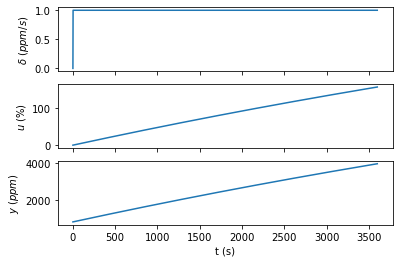

In [30]:
H_u_prop = (1/s)*C_prop/(1-(1/s)*C_prop*P)

t_max = 3600
d = np.full(3600,1) # ambient CO2 rate = +1 ppm/s
d[0] = 0
t = np.arange(0,3600)

[t_u,u,x_u] = control.forced_response(H_u_prop,T=t,U=d) 
[t_y,y,x_y] = control.forced_response(H_d_prop,T=t,U=d)
# x: "time evolution of the state vector" what is the state vector? by examination, x_y=[-y,u]

fig, ax = pp.subplots(nrows=3, ncols=1)

ax[0].plot(t,d)
ax[0].set_ylabel('$\delta$ $(ppm/s)$')
ax[0].set_xticklabels([])

ax[1].plot(t_u,u)
ax[1].set_ylabel('$u$ $(\%)$')
ax[1].set_xticklabels([])

ax[2].plot(t_y,y+800)
ax[2].set_ylabel('$y$ $(ppm)$')
ax[2].set_xlabel('t (s)')

pp.show()

Notice the added 800 to $y$. This is the set point of the system, $R$.

## Designing a proportional-integral controller

Let's add an integral term to avoid the endless oscillation that the proportional controller produces. For simplicity, let's design it visually. We also need to add saturation, since the percent brightness can't get below zero or above one hundred.

The D in the PID controller is large if the slope of y is large. The P is large if y is large. The I is large if the area under y is large.

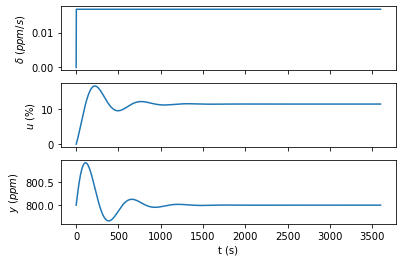

In [50]:
C_PI = 5 + 0.1/s

# good controllers:
# C_PI = 5 + 0.1/s

H_u_PI = (1/s)*C_PI/(1-(1/s)*C_PI*P)
H_d_PI = (1/s)/(1-(1/s)*C_PI*P)

t_max = 3600
d = np.full(3600,1/60) # ambient CO2 rate = +1 ppm/s
d[0] = 0
t = np.arange(0,3600)

[t_u,u,x_u] = control.forced_response(H_u_PI,T=t,U=d) 
[t_y,y,x_y] = control.forced_response(H_d_PI,T=t,U=d)
# x: "time evolution of the state vector" what is the state vector? by examination, x_y=[-y,u]

fig, ax = pp.subplots(nrows=3, ncols=1)

ax[0].plot(t,d)
ax[0].set_ylabel('$\delta$ $(ppm/s)$')
ax[0].set_xticklabels([])

ax[1].plot(t_u,u)
ax[1].set_ylabel('$u$ $(\%)$')
ax[1].set_xticklabels([])

ax[2].plot(t_y,y+800)
ax[2].set_ylabel('$y$ $(ppm)$')
ax[2].set_xlabel('t (s)')

pp.show()

A large coefficient of $\frac{1}{s}$ causes the system to go unstable. Also note that a small coefficient of $s$ would cause the system to go unstable. Also note that the smaller the $K_p$ the more unstable the system, so I bumped it up to a larger value than in the proportional controller section. Now maximum brightness occurs at 1800 ppm.

- *Add saturation (u is constrained 0-100, and y is constrained >0)*
- *Is there a way to increase the maximimum PWM brightness of the LEDs? (Would be nice to have a wider response range, but not critical.)*

## A different method for designing a controller $C(s)$
### Determining the equation
In order to respond to elevated levels and rates of CO2 without using too much energy (that is, without keeping the lights on high all the time), we can design a PID controller.

<div class="alert alert-block alert-info">
<b>What do the P, I, and D terms mean?</b>
    
*Term P* is proportional to the current value of the $SP-PV$ error. So, if the error is large the control output, the voltage, will be proportionately large, leading to bright lights and a high photosynthesis rate.

*Term I* accounts for past values of the $SP−PV$ error and integrates them over time to produce the I term. For example, if there is a residual $SP−PV$ error after the application of proportional control, the integral term seeks to eliminate the residual error by adding a control effect due to the historic cumulative value of the error.

*Term D* is a best estimate of the future trend of the $SP−PV$ error, based on its current rate of change. The more rapid the change, the greater the controlling or damping effect. So, if the CO2 level is increasing rapidly, this term will result in a larger voltage command to the lights.
</div>

Let's first specify a couple system requirements in order to know which damping ratio and natural frequency we should be aiming for the system to have. The CO2 level should get within 2% of the reference in an hour and overshoot the reference by no more than 20%, so settling time $T_s=3600s$ and percent overhoot $\%OS=20\%$. Thus:

$$\zeta = \frac{-ln(\%OS/100)}{\sqrt{\pi^2+ln(\%OS/100)}} = 0.46$$
and $$\omega_n=\frac{4}{\zeta T_s}=2.44\times10^{-3}s^{-1}$$

Now we can plot where the poles of the closed loop system (*?*) need to be in order to satisfy the system requirements. (*make sure the system [behaves as second order](https://youtu.be/WLBszzT0jp4?list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f&t=610) so this applies*)

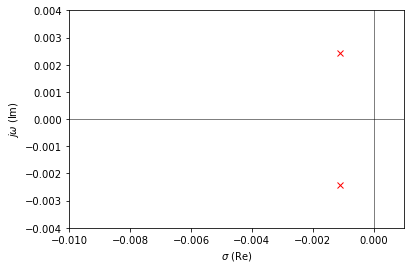

In [7]:
zeta = 0.46
w_n = 2.44e-3
Re = -zeta*w_n
Im = w_n

fig, ax = pp.subplots()
ax.plot([Re,Re],[Im,-Im],'rx')
ax.axis([-1e-2, 1e-3, -4e-3, 4e-3])
ax.set_xlabel('$\sigma$ (Re)')
ax.set_ylabel('$j\omega$ (Im)')
ax.axhline(0,lw=0.5,c='k') # x = 0
ax.axvline(0,lw=0.5,c='k') # y = 0
pp.show()

Now let's take a look at how the system would behave if we used a simple gain (P) controller. That will show us whether we actually need a more complex controller to meet our design requirements. We'll plot the root locus of a feedback system consisting of that controller, $K_p$, inline with the plant. The OLTF of the P compensated system is

$$C(s)P(s)=K_p\frac{1.446\times10^{-3}}{s}$$

which means that the CLTF is $$H_p(s)= \frac{K_p\frac{1.446\times10^{-3}}{s}}{1-K_p\frac{1.446\times10^{-3}}{s}}$$

The root locus diagram is a plot of how the poles (*why not also the zeroes?*) (*what does knowing the location of the poles tell us?*) of the CLTF vary as K varies. In order to find those poles, we set the denominator of $H_p(s)$ equal to zero. Then we plot the solution ($s$) to that characteristic equation, $1-K_pP(s)=0$, in the s-plane as $K_p$ varies from 0 to $\infty$.

From the Python Control Systems Library documentation for ``control.root_locus``: "Calculate the root locus by finding the roots of 1+k\*TF(s)." So to find the roots of 1-k*TF(s), I pass in $P$ as $-P$.

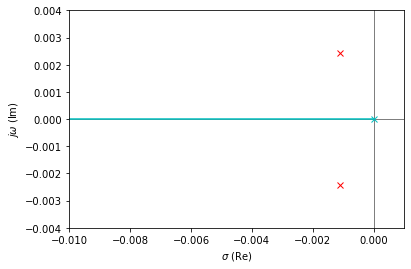

In [8]:
rlist, klist = control.root_locus(-P,Plot=False) # -P since the output is added at the summing junction
sigma = [x.real for x in rlist]
jw = [x.imag for x in rlist]
ax.plot(sigma,jw,'c',)
ax.plot(rlist[0],0,'cx')
fig

*OR (interesting!) "A root locus diagram is a plot that shows how the eigenvalues of a linear (or linearized) system change as a function of a single parameter..."[*](https://www.cds.caltech.edu/~murray/amwiki/index.php/Root_Locus_Diagram)*

The x marks the one open loop pole of the system, which is where $K_p=0$ (*0•P(s)=0, how does that work?*). Stated differently, x is at the value of $s$ that causes $P(s)=\frac{K_L K_P}{s}$ to go to infinity. [Here is a video](https://www.youtube.com/watch?v=LYd2D8NqLOc) that explains why the root locus of the closed loop transfer function $H_p(s)$ terminates at the poles (and zeroes) of the open loop transfer function $P(s)$.

The pole will move along the blue line as $K_p$ varies, but will never reach either red x, which indicates that we need something more than a proportional controller. This makes sense, because our open loop transfer function is only first order. To achieve two poles, we need to increase the order of the OLTF denominator.

Because we want to respond to both level and cumulative effect of the CO2, let's use a PI controller to increase the denominator order. *(actually it might be a PD controller, since we want to respond to high rates with bright lights, but let's try Garbini's suggestion for now.)* (*intuition/explanation why adding an I will make the curve split*) (*does adding I improve disturbance handling?*)

In time, a PID controller will be as follows.

$$u(t)=K_pe(t)+K_i\int_0^t{e(\tau)d\tau}+K_d\frac{de(t)}{dt}$$

Since we are building a PI controller, $K_d=0$. Taking a [Laplace transform](https://tutorial.math.lamar.edu/classes/de/laplace_table.aspx) to transform the controller to the ~frequency~ **s-**domain (*why not frequency domain?*), we get

$$U(s) = K_pE(s)+K_i\frac{E(s)}{s}$$

so $$C(s) = \frac{U(s)}{E(s)} = K_p+\frac{K_i}{s} = K_p\frac{\left(s+\frac{K_i}{K_p}\right)}{s}$$

So, as the equation indicates, a PI controller adds a zero at $-\frac{K_i}{K_p}$ and a pole at the origin. Note that the final form above is in *zpk format*. The open loop transfer function of the PI compensated system looks like this:

$$C(s)P(s)=K_p\frac{\left(s+\frac{K_i}{K_p}\right)}{s}\frac{K_LK_P}{s}$$

### Determining the gains
Now we need to choose values for $K_p$ and $K_i$. Or, another way to think about it that we will move the location of the zero, in addition to changing the common gain $K_p$.[*](https://youtu.be/Hk6YBO_A_PU?t=490) Let's try setting the zero first in order to shape the root locus, then we'll change $K_p$ to put the poles where we want them on the root locus. *(Is there a way to figure out mathematically what $-\frac{K_i}{K_p}$ should be?*)

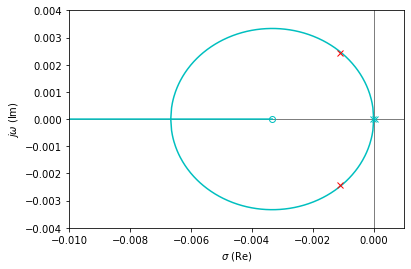

In [48]:
z = -40/11999 # -K_i/K_p; why is this so dumb?
C = (s-z)/s # justification for this being negative...
sys = control.series(1/s,P,C)

fig, ax = pp.subplots()
ax.axis([-1e-2, 1e-3, -4e-3, 4e-3])
ax.set_xlabel('$\sigma$ (Re)')
ax.set_ylabel('$j\omega$ (Im)')
ax.axhline(0,lw=0.5,c='k') # x = 0
ax.axvline(0,lw=0.5,c='k') # y = 0
rlist, klist = control.root_locus(-sys,Plot=False) # once again, -sys because it's a positive feedback system
sigma = [x.real for x in rlist]
jw = [x.imag for x in rlist]
ax.plot(sigma,jw,'c',)
ax.plot([-0.00003,0.00003],[0,0],'cx') # plot origin poles slightly offset for visibility
ax.plot(z,0,'co',fillstyle='none')
ax.plot([Re,Re],[Im,-Im],'rx')
pp.show()

A $-\frac{K_i}{K_p}$ ratio of about $-\frac{1}{300}$ produces a root locus that contains the two open loop poles we're trying to achieve. We could also say that we put a zero at $-\frac{1}{300}$ and a pole at the origin. Now we just need to find the value of $K_p$ that will result in the desired open loop poles, which we will do using the magnitude criterion:

$$|KG(s)H(s)|=1$$
so
$$K_p = \frac{1}{|C(s)P(s)|} = \frac{\Pi\textrm{ pole lengths}}{\Pi\textrm{ zero lengths}}$$

*(from Nise eqn. 8.14 and 8.21)*

Explained graphically:

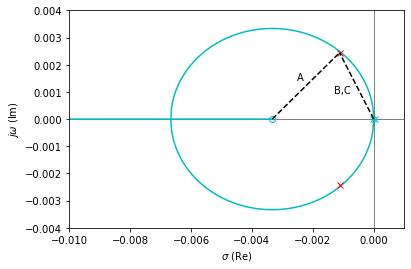

In [10]:
x1 = [z,Re]
x2 = [0,Re]
y = [0,Im]
ax.plot(x1,y,'k--',label='A')
ax.plot(x2,y,'k--',label='B,C')
ax.text(z+.0008,Im/2+.0002,'A')
ax.text(Re/2-.00075,Im/2-.00025,'B,C')
fig

In [11]:
mag_A = np.sqrt((x1[1]-x1[0])**2+(y[1]-y[0])**2)
mag_BC = np.sqrt((x2[1]-x2[0])**2+(y[1]-y[0])**2)
K_p = 2*mag_BC/mag_A
K_i = -z*K_p
print('K_p =',K_p)
print('K_i =',K_i)

K_p = 1.6312616653839402
K_i = 0.005437992050617352


In [47]:
C = K_p+K_i/s
sys = C*P
print('PI compensated OLTF:\n',(1/s)*sys)

PI compensated OLTF:
 
-0.002359 s - 7.864e-06
-----------------------
          s^2



*is it coincidence that K_p/K_i is pretty much exactly 300? probably not. why is it?*

### Complete feedback loop
The closed loop model is almost complete. We only need to add a disturbance in CO2 rate to represent the rate that CO2 will be added to the ambient environment by a human or another process. This results in the following closed loop system.

![](bioreactorcontroller.png)

where

In [13]:
R = 800 # ppm
print("R =",R,"\tppm")
print("K_p =",round(K_p,2),"\t%/ppm")
print("K_i =",round(K_i,5),"\t%*s/ppm")
print("K_L =",K_L,"\tlux/%")
print("K_P =",K_P,"ppm/lux*s")

R = 800 	ppm
K_p = 1.63 	%/ppm
K_i = 0.00544 	%*s/ppm
K_L = 41.4 	lux/%
K_P = -3.493e-05 ppm/lux*s


[Units might be wrong]

### Simulations
This derivation is adapted from a [video by Steve Brunton](https://youtu.be/vxTJMGqjGdg?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m&t=912). 

The state space representation of the plant is as follows

$$\dot x = Pu + \delta$$
$$y = x$$

where $P=K_LK_P$. $x(t)$ physically represents the rate of change of ambient carbon dioxide concentration, and recall that $u(t)$ is the PWM percentage. Continuing from an earlier equation,

$$u = K_p(y-r)+K_i\int (y-r) dt$$

Let's create a new state variable, $z$.

$$\dot z = y-r = x-r$$

Thus,

$$u = K_p(x-r)+K_iz$$

Plugging into the equation for the state variable $\dot x$,

$$\dot x = PK_p(x-r)+PK_iz+\delta$$

So the state space representation of the compensated system, now in matrix form, is as follows.

$$
\frac{d}{dt}\left[\begin{array}{aa} x\\z \end{array}\right]
=\left[\begin{array}{aa} PK_p & PK_i \\ 1 & 0 \end{array}\right] \left[\begin{array}{aa} x\\z \end{array}\right]
+\left[\begin{array}{aa} -PK_p\\-1 \end{array}\right] r
+\left[\begin{array}{aa} 1\\0 \end{array}\right]\delta
$$

$$y=\left[\begin{array}{aa} 1 & 0 \end{array}\right] \left[\begin{array}{aa} x\\z \end{array}\right]$$

Let's first simulate the response of the bioreactor ($y(t)$; that is, the ambient carbon dioxide concentration) to a step change in PWM signal from 0% to 100%. Putting the coefficients from the plant in standard A, B, C, D state space form:

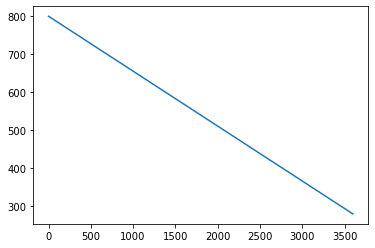

In [14]:
A = 0
B = K_L*K_P
C = 1
D = 0

u = np.full(3600,100) # duty cycle = 100%

sys_plant = control.ss(A, B, C, D)

[t_P,y_P,x_P] = control.forced_response(sys_plant,T=np.arange(0,3600),U=u,X0=800) # CO2 concentration response to a step in PWM duty cyle (in percent)
# y_P: carbon dioxide concentration
# x_P: "time evolution of the state vector" what is the state vector?
pp.plot(t_P,y_P)

Let's also note the state equation for $u(t)$, the PWM duty cycle response.

$$u=\left[\begin{array}{aa} K_p & K_i \end{array}\right] \left[\begin{array}{aa} x\\z \end{array}\right]+\left[\begin{array}{aa} -K_p \end{array}\right]r$$

Now we plot the responses $y(t)$ and $u(t)$ to a $1\frac{ppm}{min}$ step increase in ambient carbon dioxide rate.

*[is R really just not used?]*

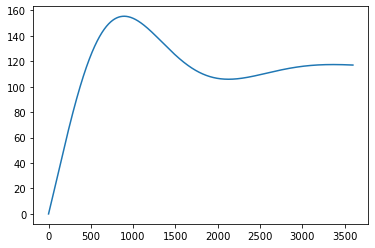

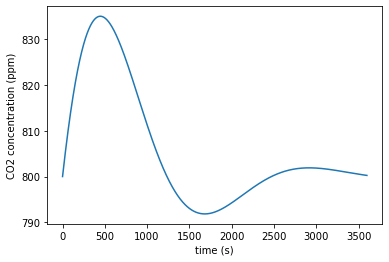

In [15]:
A = [[K_L*K_P*K_p,K_L*K_P*K_i],[1,0]]
B = [[1],[0]] # we want to simulate what happens for a step input in d
C = [1,0]
C_u = [K_p,K_i]
D = 0

d = np.full(3600,1/6)

sys_PI = control.ss(A,B,C,D)
[t_PI,y_PI,x_PI] = control.forced_response(sys_PI,T=np.arange(0,3600),U=d)

sys_PI_u = control.ss(A,B,C_u,D)
[t_PI1,u_PI1,x_PI1] = control.forced_response(sys_PI_u,T=np.arange(0,3600),U=d)
pp.plot(t_PI1,u_PI1)

# plot
fig_s, ax_s = pp.subplots()
ax_s.set_xlabel('time (s)')
ax_s.set_ylabel('CO2 concentration (ppm)')
pp.plot(t_PI,y_PI+800)



# Helpful resources
---
## A comparison of the types of compensators and controllers
- [what are lead lag compensators?](https://www.youtube.com/watch?v=xLhvil5sDcU)

### Lead compensation
Lead compensators can be used to move the dominant poles (the ones that are responsible for the majority of the response) to the left in order to increase system stability (*what does that mean?*). A lead compensator adds a pole and a zero, with the pole being the smaller of the two. As long as the added pole is sufficiently small the system still behaves more or less like a second order system, which means we can still use damping ratio and natural frequency of the second order charactistic polynomial (remember, the bottom of the compensated OLTF) to meet system requirements. For example:

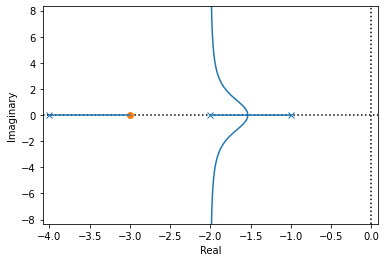

In [16]:
G = 1/((s+1)*(s+2)) # plant
z_l = -3
p_l = -4
C_lead = (s-z_l)/(s-p_l) # lead compensator
r, k = control.root_locus(G*C_lead,grid=False)

Here's [a longer example](https://www.youtube.com/watch?v=NMpmb0ihoFo&list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f&index=4) of how a lead compensator can be designed with root locus.

### Lag compensation
Lag compensators can be used move the dominant poles to the right, but that's not usually the point. Instead lag compensators are typically used to improve steady state error, while moving the root locus as little as possible. An example is given [here](https://youtu.be/vXwOzDs5xKY?list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f&t=165).

*why would we want a PID vs. lead/lag compensator?*

### PID compensation


## Domains
[Good explanation here](https://youtu.be/WLBszzT0jp4?list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f&t=476)

Time domain:

Frequency domain:
- Bandwidth
- Gain margin
- Phase margin
- etc.

S-domain:
- Pole/zero locations

## Calculating the closed loop transfer function
- https://eng.libretexts.org/Bookshelves/Industrial_and_Systems_Engineering/Book%3A_Introduction_to_Control_Systems_(Iqbal)/04%3A_Control_System_Design_Objectives/4.04%3A_Disturbance_Rejection
- https://youtu.be/y4H03UOjlas?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m&t=674

**[Control Bootcamp: Cruise Control Example with Proportional-Integral (PI) control](https://youtu.be/vxTJMGqjGdg?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m)**:


---
which design method to use?`
- [Root locus design in Python](https://digital.library.txstate.edu/handle/10877/11938)

*next*
- understand fourier and laplace transform
    - https://electronics.stackexchange.com/questions/86489/relation-and-difference-between-fourier-laplace-and-z-transforms
    - https://www.youtube.com/watch?v=7UvtU75NXTg
- controller design
    - do we need lead-lag? ("Situations may occur where there are excessive delays: the measurement of the process value is delayed, or the control action does not apply quickly enough.")
- understand the relationship between the poles and eigenvalues
- which design techniques could I have used besides root locus?
- add saturation: https://www.youtube.com/watch?v=6ivdfKfGp4k
- calculate steady-state error of the compensated system: https://www.youtube.com/watch?v=vXwOzDs5xKY&list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f&index=5 (very helpful)

*helpful links*
- https://stackoverflow.com/questions/47053517/is-it-possible-to-generate-proper-root-locus-plots-with-python-3
- [Controllers and compensators](https://en.wikibooks.org/wiki/Control_Systems/Controllers_and_Compensators)
- [Discussion of the difference between controllers and compensators](https://www.researchgate.net/post/Controller-Vs-Compensator)
- [Root locus method video series](https://www.youtube.com/playlist?list=PLUMWjy5jgHK3-ca6GP6PL0AgcNGHqn33f)

The solutions, or the roots, of the characteristic equation are the poles of the closed loop system. when k=0, the solutions of the char. eqn. are the poles of the plant